In [1]:
import numpy as np
import random
import torch
from gpytorch.kernels import ScaleKernel, RBFKernel
from linear_operator.operators import KroneckerProductLinearOperator
from torch import Tensor
from torch.distributions import MultivariateNormal
from lvmogp_svi import LVMOGP_SVI
from gaussian_likelihood import GaussianLikelihood
from variational_elbo import VariationalELBO
from tqdm import trange
from torch.optim.lr_scheduler import StepLR
from util_functions import *
import gpytorch

## Get data ready -- without missing value

In [2]:
# This section is same as 'no missing data' case.
idgp_w_n_C_total = 700 # totally 700 points for C
idgp_w_n_outputs = 20

In [3]:
expri_random_seed = 0

np.random.seed(expri_random_seed)
list_expri_random_seeds = np.random.randn(idgp_w_n_outputs)
print(list_expri_random_seeds)

[ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985   0.14404357  1.45427351
  0.76103773  0.12167502  0.44386323  0.33367433  1.49407907 -0.20515826
  0.3130677  -0.85409574]


In [4]:
# The following code generates all output data.
idgp_w_X_true, idgp_w_C_total, idgp_w_sample_total_data, kernel_parameters = tidily_sythetic_data_from_MOGP(n_C=idgp_w_n_C_total, n_X=idgp_w_n_outputs)

idgp_w_n_C_train = 50 # the number of training data points per output
idgp_w_n_C_test = idgp_w_n_C_total - idgp_w_n_C_train

# different from the previous case, C_train and C_test no longer a single set, but every output has different values.
idgp_w_ls_of_ls_train_C = []
idgp_w_ls_of_ls_test_C = []

idgp_w_sample_train_index, idgp_w_sample_test_index = [], []

for i in range(idgp_w_n_outputs):
    # iterate across different output functions
    random.seed(list_expri_random_seeds[i])
    train_index = random.sample(range(idgp_w_n_C_total), idgp_w_n_C_train)
    test_index = [index for index in range(idgp_w_n_C_total) if index not in train_index]
    idgp_w_ls_of_ls_train_C.append(train_index)
    idgp_w_ls_of_ls_test_C.append(test_index)
    
    idgp_w_sample_train_index = np.concatenate((idgp_w_sample_train_index, list(np.array(train_index) + idgp_w_n_C_total*i)))
    idgp_w_sample_test_index = np.concatenate((idgp_w_sample_test_index, list(np.array(test_index) + idgp_w_n_C_total*i)))

idgp_w_sample_train_data = idgp_w_sample_total_data[idgp_w_sample_train_index]
idgp_w_sample_test_data = idgp_w_sample_total_data[idgp_w_sample_test_index]

# data for all outouts ...
assert idgp_w_sample_train_data.shape[0] == idgp_w_n_C_train * idgp_w_n_outputs
assert idgp_w_sample_test_data.shape[0] == idgp_w_n_C_test * idgp_w_n_outputs
assert idgp_w_sample_total_data.shape[0] == idgp_w_n_C_total * idgp_w_n_outputs

In [16]:
# pick the index of the output function, range from 0 to idgp_n_outputs
idgp_function_index = 5

In [17]:
# Data
idgp_train_start = idgp_function_index * idgp_w_n_C_train
idgp_train_end = idgp_train_start + idgp_w_n_C_train

idgp_test_start = idgp_function_index * idgp_w_n_C_test
idgp_test_end = idgp_test_start + idgp_w_n_C_test

idgp_total_start = idgp_function_index * idgp_w_n_C_total
idgp_total_end = idgp_total_start + idgp_w_n_C_total

# training data
train_X = idgp_w_C_total[idgp_w_ls_of_ls_train_C[idgp_function_index]]
train_Y = idgp_w_sample_train_data[idgp_train_start:idgp_train_end]
assert train_X.shape ==  train_Y.shape == torch.Size([idgp_w_n_C_train])

# testing data
test_X = idgp_w_C_total[idgp_w_ls_of_ls_test_C[idgp_function_index]]
test_Y = idgp_w_sample_test_data[idgp_test_start:idgp_test_end]
assert test_X.shape == test_Y.shape == torch.Size([idgp_w_n_C_test])

# total data, of length idgp_n_C_total
total_X = idgp_w_C_total
total_Y = idgp_w_sample_total_data[idgp_total_start:idgp_total_end]
assert total_X.shape == total_Y.shape == torch.Size([idgp_w_n_C_total])

In [18]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

# Model
class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [19]:
# Hyperparameters
idgp_n_inducing_C = 15
learning_rate = 0.01

In [20]:
from gaussian_likelihood import GaussianLikelihood
from variational_elbo import VariationalELBO

inducing_points = torch.rand(idgp_n_inducing_C).reshape(-1,1) * 20 - 10
model = GPModel(inducing_points=inducing_points)
likelihood = GaussianLikelihood()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

#### Training

In [21]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=learning_rate)

wo_scheduler = StepLR(optimizer, step_size=50, gamma=0.95)  # 0.3, 50, 0.95; 

# Our loss object. We're using the VariationalELBO
mll = VariationalELBO(likelihood, model, num_data=train_Y.size(0))

# have a look at parameters
for name, param in model.named_parameters():
    print(name, param.size())
    
# start training!
idgp_loss_list = []
n_iterations = 2500 # 1500 # 10000
iterator = trange(n_iterations, leave=True)
idgp_model_max_grad_norm = 15
idgp_likeli_max_grad_norm = 0.7

for i in iterator:
    optimizer.zero_grad()
    output_pred = model(train_X)
    loss = -mll(output_pred, train_Y)
    idgp_loss_list.append(loss.item())
    iterator.set_description('Loss: ' + str(float(np.round(loss.item(),3))) + ", iter no: " + str(i))
    loss.backward()

    # clip gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), idgp_model_max_grad_norm)
    torch.nn.utils.clip_grad_norm_(likelihood.parameters(), idgp_likeli_max_grad_norm)

    optimizer.step()
    wo_scheduler.step()

variational_strategy.inducing_points torch.Size([15, 1])
variational_strategy._variational_distribution.variational_mean torch.Size([15])
variational_strategy._variational_distribution.chol_variational_covar torch.Size([15, 15])
mean_module.raw_constant torch.Size([])
covar_module.raw_outputscale torch.Size([])
covar_module.base_kernel.raw_lengthscale torch.Size([1, 1])


  0%|          | 0/2500 [00:00<?, ?it/s]

Loss: 0.13, iter no: 2499: 100%|██████████| 2500/2500 [00:47<00:00, 53.12it/s] 


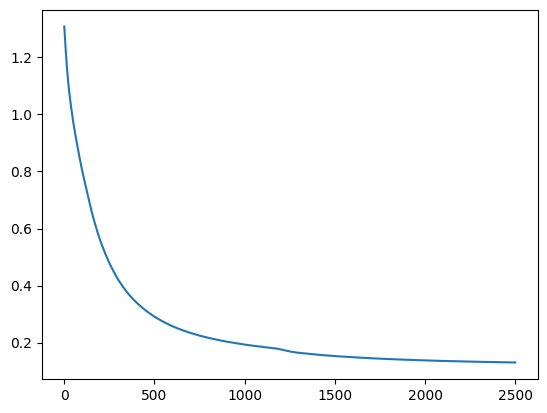

In [22]:
import matplotlib.pyplot as plt

plt.plot(idgp_loss_list)

In [23]:
print('After Training, have a look at fitted kernel parameters...\n')

print('model covar_module output scale\n', model.covar_module.outputscale.data)
print('model covar_module length scale\n', model.covar_module.base_kernel.lengthscale.data)

print('----- ----- ' * 10)

print('likelihood noise_covar noise', likelihood.noise_covar.noise.data)

After Training, have a look at fitted kernel parameters...

model covar_module output scale
 tensor(0.3155)
model covar_module length scale
 tensor([[0.5543]])
----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 
likelihood noise_covar noise tensor([0.0017])


#### Testing

In [24]:
model.eval()
likelihood.eval()
# Train/Test/Total data
idgp_train_output_dist = likelihood(model(train_X))
idgp_test_output_dist  = likelihood(model(test_X))
idgp_total_output_dist = likelihood(model(total_X))

idgp_train_output_pred_mean = idgp_train_output_dist.loc.detach()
idgp_test_output_pred_mean = idgp_test_output_dist.loc.detach()
idgp_total_output_pred_mean = idgp_total_output_dist.loc.detach()

idgp_total_output_pred_std = idgp_total_output_dist.stddev.detach()

assert idgp_train_output_pred_mean.shape == train_Y.shape
assert idgp_test_output_pred_mean.shape == test_Y.shape

#### Train/Test RMSE

In [25]:
idgp_train_rmse = (idgp_train_output_pred_mean - train_Y).square().mean().sqrt()
idgp_test_rmse = (idgp_test_output_pred_mean - test_Y).square().mean().sqrt()

print('Train RMSE', idgp_train_rmse)
print('Test RMSE', idgp_test_rmse)

Train RMSE tensor(0.2537)
Test RMSE tensor(0.4923)


#### Visual Inspect

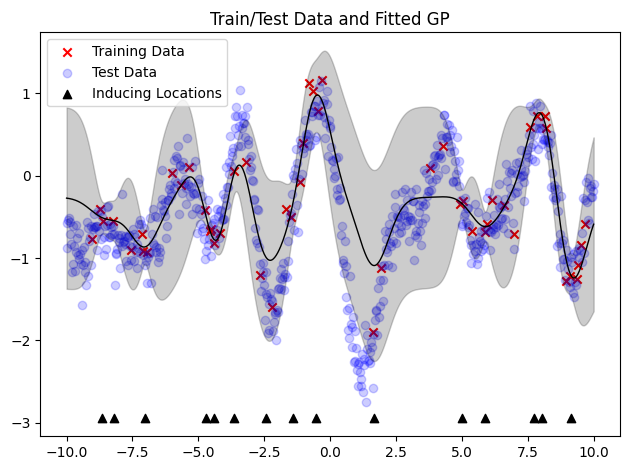

In [26]:
plot_traindata_testdata_fittedgp(train_X=train_X, train_Y=train_Y, test_X=test_X, test_Y=test_Y, gp_X=total_X, gp_pred_mean=idgp_total_output_pred_mean, gp_pred_std=idgp_total_output_pred_std, inducing_points_X=model.variational_strategy.inducing_points.detach(), n_inducing_C=idgp_n_inducing_C) # NOTE: input is C not X